In [2]:
from altaipony.injrecanalysis import plot_heatmap, tile_up_injection_recovery
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
df = pd.read_csv("/work1/eilin/TESS_UCDs/injrec/2_1000_000070555405_s0003.csv")


In [28]:
df = df.drop_duplicates()
df.shape

(2000, 14)

In [29]:
dff, val = tile_up_injection_recovery(df, "recovery_probability",ampl_bins=20, dur_bins=20
                                     )

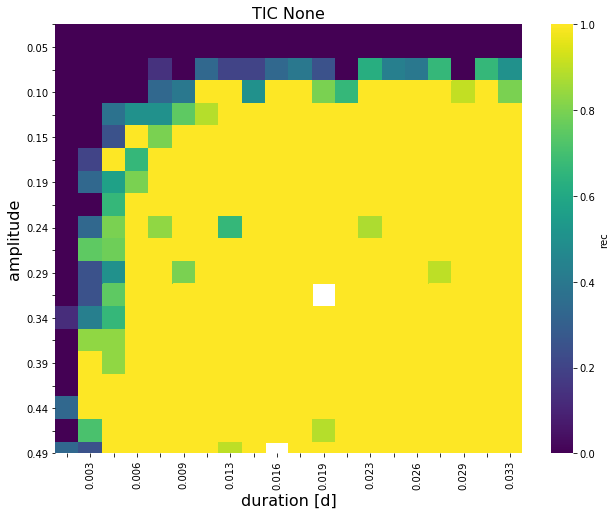

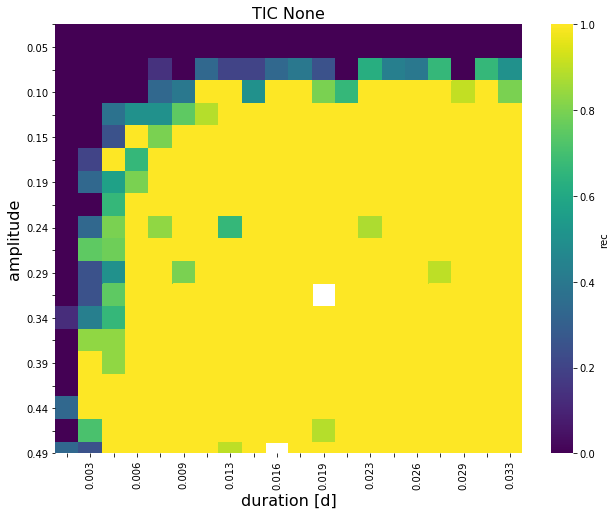

In [30]:
plot_heatmap(dff, val)

In [31]:
from altaipony.lcio import from_mast


In [32]:
flc = from_mast(70555405, c=3, mission="TESS", cadence="short")

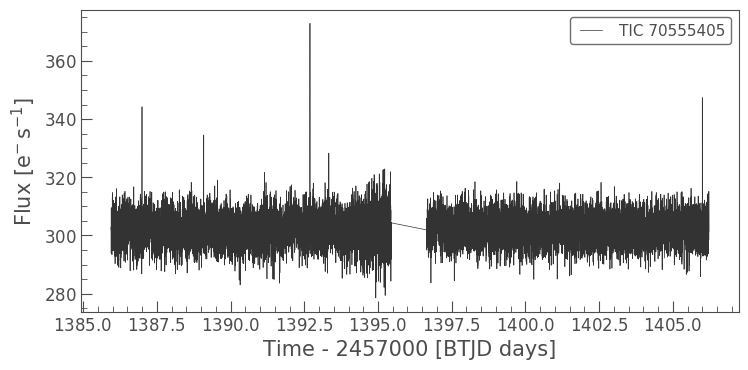

In [34]:
flc.plot()
#plt.xlim(1392, 1395)